# Import packages

In [7]:
import io
import os
import random
import re
import requests
import time
import typing
from typing import Any, Callable, Dict, Type
import warnings

from boruta import BorutaPy
import numpy as np
import optuna
from optuna.visualization import plot_optimization_history, plot_contour, plot_edf, \
    plot_intermediate_values, plot_optimization_history, plot_parallel_coordinate, \
    plot_param_importances, plot_slice
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestRegressor
from sb3_contrib.tqc import TQC
from scipy.stats import norm
import seaborn as sns
from stable_baselines3.a2c import A2C
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import configure
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.sac import SAC
import stockstats
import torch as th
import tushare
import yfinance as yf

from environment.MultiStockTradingEnv import MultiStockTradingEnv
from quantile_critic.tqci import TQCI
from quantile_critic.tqcr import TQCR
from utils.sample_funcs import *
from utils.utils import *

# Config

In [8]:
warnings.simplefilter(action='ignore', category=FutureWarning)

TRAIN_START_DAY = '2008-01-01'
TRAIN_END_DAY = '2016-12-31'
TEST_START_DAY = '2017-01-01'
TEST_END_DAY = '2019-12-31'
TRADE_START_DAY = '2020-01-01'
TRADE_END_DAY = '2022-12-31'

# Setup directories
DATA_SAVE_DIR = 'datasets'
MODEL_DIR = 'models'
MODEL_TRAINED_DIR = os.path.join(MODEL_DIR, 'trained')
TENSORBOARD_LOG_DIR = 'tensorboard_log'
RAW_DATA_DIR = os.path.join(DATA_SAVE_DIR, 'raw')
RAW_DATA_WITHIN_RANGE_DIR = os.path.join(DATA_SAVE_DIR, f'raw_{TRAIN_START_DAY}_{TRADE_END_DAY}')
CLEAN_DATA_DIR = os.path.join(DATA_SAVE_DIR, 'clean')
PREPROCESSED_DATA_DIR = os.path.join(DATA_SAVE_DIR, 'preprocessed')
PREPROCESSED_SSE50_DIR = os.path.join(PREPROCESSED_DATA_DIR, 'SSE50')
PREPROCESSED_HSI_DIR = os.path.join(PREPROCESSED_DATA_DIR, 'HSI')
PREPROCESSED_DJIA_DIR = os.path.join(PREPROCESSED_DATA_DIR, 'DJIA')
PREPROCESSED_DAX30_DIR = os.path.join(PREPROCESSED_DATA_DIR, 'DAX30')


check_and_make_directories([
     DATA_SAVE_DIR, MODEL_DIR, MODEL_TRAINED_DIR, TENSORBOARD_LOG_DIR, \
     RAW_DATA_DIR, RAW_DATA_WITHIN_RANGE_DIR, CLEAN_DATA_DIR, PREPROCESSED_DATA_DIR, \
     PREPROCESSED_SSE50_DIR, PREPROCESSED_HSI_DIR, PREPROCESSED_DJIA_DIR, PREPROCESSED_DAX30_DIR
     ])

tushare_token = '2bf5fdb105eefda26ef27cc9caa94e6f31ca66e408f7cc54d4fce032'

# Download and prerocess data

## SSE50

### Retrieve SSE 50 component list

In [70]:
# SSE 50 components from http://www.sse.com.cn/market/sseindex/indexlist/basic/index.shtml?COMPANY_CODE=000016&INDEX_Code=000016&type=1
SSE50_COM = \
"""
包钢股份(600010)	中国石化(600028)	中信证券(600030)
三一重工(600031)	招商银行(600036)	保利发展(600048)
上汽集团(600104)	北方稀土(600111)	复星医药(600196)
恒瑞医药(600276)	万华化学(600309)	恒力石化(600346)
国电南瑞(600406)	片仔癀(600436)	    通威股份(600438)
贵州茅台(600519)	海螺水泥(600585)	海尔智家(600690)
闻泰科技(600745)	山西汾酒(600809)	伊利股份(600887)
航发动力(600893)	长江电力(600900)	三峡能源(600905)
隆基绿能(601012)	中信建投(601066)	中国神华(601088)
兴业银行(601166)	陕西煤业(601225)	农业银行(601288)
中国平安(601318)	工商银行(601398)	中国太保(601601)
中国人寿(601628)	长城汽车(601633)	中国建筑(601668)
中国电建(601669)	华泰证券(601688)	中国石油(601857)
中国中免(601888)	紫金矿业(601899)	中远海控(601919)
中金公司(601995)	药明康德(603259)	合盛硅业(603260)
海天味业(603288)	韦尔股份(603501)	华友钴业(603799)
兆易创新(603986)	天合光能(688599)
"""

In [71]:
tic_list = re.findall(r'\d{6}', SSE50_COM)
tic_list = [tic+'.SS' for tic in tic_list]

### Download SSE50 ticker history with yfinace

In [4]:
def download_ticker_with_yfince(tic_list: List[str], download_dir: str) -> List[str]:
    retry_list = []
    for tic in tic_list:
        if tic.startswith('CON'):
            csv_path = os.path.join(download_dir, f'_{tic}.csv')
        else:
            csv_path = os.path.join(download_dir, f'{tic}.csv')
            
        if os.path.exists(csv_path):
            print(f'File {csv_path} already exist. Skip')
            continue
        
        ticker = yf.Ticker(tic)
        df = ticker.history(period='max')
        if df.shape[0] > 0:
            df.to_csv(csv_path)
            print(f'Download {tic}.csv')         
            time.sleep(0.1)
        else:
            retry_list.append(tic)
    
    return retry_list

In [25]:
retry_list = download_ticker_with_yfince(tic_list, RAW_DATA_DIR)

File datasets\raw\600010.SS.csv already exist. Skip
File datasets\raw\600028.SS.csv already exist. Skip
File datasets\raw\600030.SS.csv already exist. Skip
File datasets\raw\600031.SS.csv already exist. Skip
File datasets\raw\600036.SS.csv already exist. Skip
File datasets\raw\600048.SS.csv already exist. Skip
File datasets\raw\600104.SS.csv already exist. Skip
File datasets\raw\600111.SS.csv already exist. Skip
File datasets\raw\600196.SS.csv already exist. Skip
File datasets\raw\600276.SS.csv already exist. Skip
File datasets\raw\600309.SS.csv already exist. Skip
File datasets\raw\600346.SS.csv already exist. Skip
File datasets\raw\600406.SS.csv already exist. Skip
File datasets\raw\600436.SS.csv already exist. Skip
File datasets\raw\600438.SS.csv already exist. Skip
File datasets\raw\600519.SS.csv already exist. Skip
File datasets\raw\600585.SS.csv already exist. Skip
File datasets\raw\600690.SS.csv already exist. Skip
File datasets\raw\600745.SS.csv already exist. Skip
File dataset

In [ ]:
retry_list = download_ticker_with_yfince(retry_list, RAW_DATA_DIR)

### Download data with adjusted price from yfinace within range

In [5]:
def download_ticker_with_yfince_within_range(tic_list, start, end):
    for tic in tic_list:
        if tic.startswith('CON'):
            csv_path = os.path.join(RAW_DATA_DIR, f'_{tic}.csv')
        else:
            csv_path = os.path.join(RAW_DATA_DIR, f'{tic}.csv')

        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path, index_col=False)
            first_day = df['Date'].iloc[0].split(' ')[0]
            last_day = df['Date'].iloc[-1].split(' ')[0]
            if first_day < start and last_day > end:
                if tic.startswith('CON'):
                    csv_path = os.path.join(RAW_DATA_WITHIN_RANGE_DIR, f'_{tic}.csv')
                else:
                    csv_path = os.path.join(RAW_DATA_WITHIN_RANGE_DIR, f'{tic}.csv')
                if not os.path.exists(csv_path):
                    df_within_range = yf.download(tic, start=start, end=end)
                    df_within_range.to_csv(csv_path)
            else:
                print(f'{tic}: from {first_day} to {last_day} out of range.')

In [ ]:
download_ticker_with_yfince_within_range(tic_list, TRAIN_START_DAY, TRADE_END_DAY)

### Preprocess data

In [112]:
FEATURES = 'open high low close volume ' + 'cr-ma3 cci cr-ma1 cr-ma2 change ppoh kdjj_9 ppo ppos stochrsi'
FEATURES = FEATURES.split(' ')

In [163]:
def load_data(tic_list, load_dir):
    df_tics = pd.DataFrame()
    for tic in tic_list: 
        if tic.startswith('CON'):
            csv_path = os.path.join(load_dir, f'_{tic}.csv')
        else:
            csv_path = os.path.join(load_dir, f'{tic}.csv')

        if not os.path.exists(csv_path):
            print(f'\nFile {csv_path} doesn\'t exist. Skip')
            continue
        data = pd.read_csv(csv_path, index_col=False)

        # Use adjusted close as close
        data['Close'] = data['Adj Close'] / data['Close']
        data.rename(columns={
            'Date': 'date',
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Adj Close' : 'close',
            'Volume' : 'volume'
            }, inplace=True)

        # Adjust open high low
        data['open'] = data['open'] * data['Close']
        data['high'] = data['high'] * data['Close']
        data['low'] = data['low'] * data['Close']
        data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
        data.drop(labels=['Close'], axis='columns', inplace=True)
        data['tic'] = tic

        print('\nCleaning ', tic)
        n_rows = data.shape[0]
        data.drop_duplicates(subset=['open', 'high', 'low', 'close', 'volume'], inplace=True)
        print(f'Drop {n_rows - data.shape[0]} duplicated rows.')

        n_rows = data.shape[0]
        data = data[(data.high > data.low) & (data.high >= data.open) & (data.high >= data.close)]
        data = data[(data.low <= data.open) & (data.low <= data.close)]
        print(f'Drop {n_rows - data.shape[0]} rows with abnormal prices.')

        n_rows = data.shape[0]
        data = data[data.volume != 0]
        print(f'Drop {n_rows - data.shape[0]} rows with volume 0.')

        df_tics = pd.concat([df_tics, data], ignore_index=True)
        
    return df_tics

In [72]:
df_tics = load_data(tic_list, RAW_DATA_WITHIN_RANGE_DIR)


Cleaning  600010.SS
Drop 64 duplicated rows.
Drop 19 rows with abnormal prices.
Drop 1 rows with volume 0.

Cleaning  600028.SS
Drop 0 duplicated rows.
Drop 25 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  600030.SS
Drop 28 duplicated rows.
Drop 24 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  600031.SS
Drop 3 duplicated rows.
Drop 20 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  600036.SS
Drop 9 duplicated rows.
Drop 15 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  600048.SS
Drop 4 duplicated rows.
Drop 15 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  600104.SS
Drop 56 duplicated rows.
Drop 17 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  600111.SS
Drop 0 duplicated rows.
Drop 14 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  600196.SS
Drop 12 duplicated rows.
Drop 29 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  600276.SS
Drop 3 dupli

<AxesSubplot: ylabel='Count'>

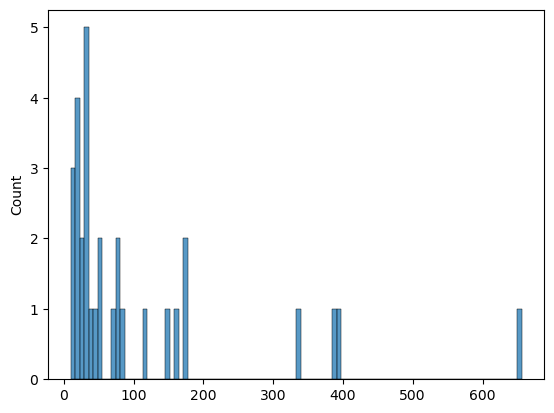

In [73]:
na_count = df_tics.pivot_table(index='date', columns=['tic']).isna().close.sum()
sns.histplot(na_count, bins=100)

Text(0.5, 0, 'NaN ratio')

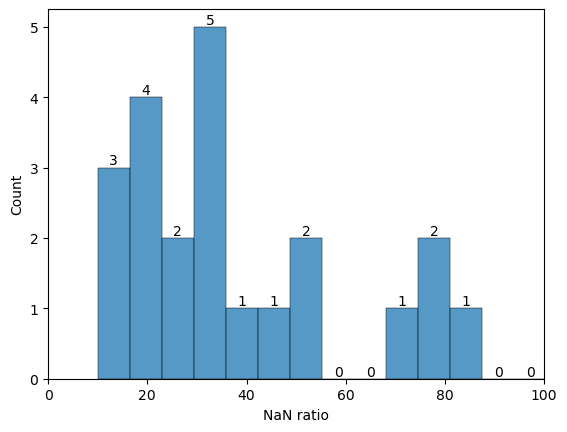

In [74]:
ax = sns.histplot(na_count, bins=100)
ax.set_xlim(0, 100)
ax.bar_label(ax.containers[1])
ax.set_xlabel('NaN ratio')

In [75]:
sr_t = df_tics.pivot_table(index='date', columns=['tic']).isna().close.sum() < 60
tic_list_ = tic_list
tic_list = list(sr_t.index[sr_t])

In [76]:
df_tics = df_tics[df_tics.tic.isin(tic_list)]
df_tics = df_tics.pivot_table(index='date', columns=['tic'])

In [77]:
df_tics.isna().close.sum()

tic
600028.SS    27
600030.SS    50
600031.SS    31
600036.SS    31
600048.SS    18
600111.SS    17
600196.SS    43
600276.SS    17
600436.SS    33
600519.SS    10
600585.SS    23
600809.SS    31
600887.SS    52
601166.SS    30
601398.SS    40
601601.SS    16
601628.SS    13
601857.SS    20
dtype: int64

In [78]:
df_tics.interpolate(method='time', axis=0).isna().close.sum()

tic
600028.SS    0
600030.SS    0
600031.SS    0
600036.SS    0
600048.SS    0
600111.SS    0
600196.SS    0
600276.SS    0
600436.SS    0
600519.SS    0
600585.SS    0
600809.SS    0
600887.SS    0
601166.SS    0
601398.SS    0
601601.SS    0
601628.SS    0
601857.SS    0
dtype: int64

In [79]:
df_tics.interpolate(method='time', axis=0, inplace=True)

In [ ]:
df_tics = df_tics.swaplevel(i = 0 , j = 1, axis = 1).stack()

In [126]:
df_tics_feat = pd.DataFrame()
for tic in df_tics.columns:
    stats = df_tics[tic].unstack().copy()
    stats = stockstats.StockDataFrame.retype(stats)

    df = pd.DataFrame(index=stats.index)
    df['tic'] = tic

    for f in FEATURES:
        df[f] = stats[f]

    # regularization
    df['close_'] = df['close']
    for col in ['open', 'high', 'low', 'close']:
        df[col] = df[col] / stats[f'{col}_250_sma'] - 1
    df['volume'] = df['volume'] / stats['volume_20_sma'] - 1

    df['cr-ma1'] -= 100
    df['cr-ma2'] -= 100
    df['cr-ma3'] -= 100
    
    # fill nan, inf
    df.replace([-np.inf, np.inf], np.nan, inplace=True)

    df.reset_index(inplace=True)

    df_tics_feat = pd.concat([df_tics_feat, df], ignore_index=True)

In [130]:
df_tics_feat.isna().sum()

date         0
tic          0
open         0
high         0
low          0
close        0
volume       0
cr-ma3       0
cci         18
cr-ma1       0
cr-ma2       0
change       0
ppoh         0
kdjj_9       0
ppo          0
ppos         0
stochrsi    43
close_       0
dtype: int64

In [134]:
df_tics_feat.date[df_tics_feat.cci.isna()].unique()

array(['2008-01-02T00:00:00.000000000'], dtype='datetime64[ns]')

In [135]:
df_tics_feat.date[df_tics_feat.stochrsi.isna()].unique()

array(['2008-01-02T00:00:00.000000000', '2008-01-03T00:00:00.000000000',
       '2008-01-04T00:00:00.000000000', '2008-01-07T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [142]:
df_tics_feat.pivot_table(values=['stochrsi', 'close'], index='tic',columns=['date']).stochrsi.iloc[:, :10].isna().sum()

date
2008-01-04    5
2008-01-07    2
2008-01-08    0
2008-01-09    0
2008-01-10    0
2008-01-11    0
2008-01-14    0
2008-01-15    0
2008-01-16    0
2008-01-17    0
dtype: int64

In [146]:
df_tics_feat = df_tics_feat[df_tics_feat.date != '2008-01-02']
df_tics_feat = df_tics_feat[df_tics_feat.date != '2008-01-03']

In [148]:
df_tics_feat.isna().sum()

date        0
tic         0
open        0
high        0
low         0
close       0
volume      0
cr-ma3      0
cci         0
cr-ma1      0
cr-ma2      0
change      0
ppoh        0
kdjj_9      0
ppo         0
ppos        0
stochrsi    7
close_      0
dtype: int64

In [150]:
df_tics_feat.fillna(method='bfill', inplace=True)

0

In [ ]:
df_tics_feat.isna().sum().sum()

In [152]:
df_tics_feat.head()

,date,tic,open,high,low,close,volume,cr-ma3,cci,cr-ma1,cr-ma2,change,ppoh,kdjj_9,ppo,ppos,stochrsi,close_
2,2008-01-04,600028.SS,0.011905,0.009604,0.020408,0.008617,0.090078,5.384646,100.000000,5.384646,5.384646,0.084145,0.024442,79.337135,0.071640,0.047199,0.000000,8.403111
3,2008-01-07,600028.SS,0.007951,0.004690,0.011678,0.000106,0.066253,5.384646,44.253399,5.384646,5.384646,-0.840330,0.000040,69.616433,0.047259,0.047219,0.000000,8.332497
4,2008-01-08,600028.SS,0.013439,0.025598,0.023392,0.020993,0.538889,5.384646,136.962637,21.323334,5.384646,2.627095,0.062856,75.169960,0.136690,0.073835,48.462340,8.551399
5,2008-01-09,600028.SS,0.016778,0.015416,0.023325,0.023008,-0.253900,5.384646,101.148608,50.535028,5.384646,0.660593,0.103420,83.668221,0.215711,0.112291,54.579641,8.607889
6,2008-01-10,600028.SS,0.021883,0.004716,0.004216,-0.004739,0.557113,5.384646,7.909684,53.127271,21.323334,-2.789157,0.016434,60.269614,0.134293,0.117859,0.000000,8.367802


In [156]:
# save
for tic in df_tics_feat.tic.unique():
    df = df_tics_feat[df_tics_feat['tic'] == tic].drop(columns=['close_', 'tic'])
    csv_path = os.path.join(PREPROCESSED_SSE50_DIR, f'{tic}.csv')
    if not os.path.exists(csv_path):
        print(f'Saving {tic}.')
        df.to_csv(csv_path, index=False)

Saving 600028.SS.
Saving 600030.SS.
Saving 600031.SS.
Saving 600036.SS.
Saving 600048.SS.
Saving 600111.SS.
Saving 600196.SS.
Saving 600276.SS.
Saving 600436.SS.
Saving 600519.SS.
Saving 600585.SS.
Saving 600809.SS.
Saving 600887.SS.
Saving 601166.SS.
Saving 601398.SS.
Saving 601601.SS.
Saving 601628.SS.
Saving 601857.SS.


## HSI

In [157]:
# Copy from https://www.hsi.com.hk/chi/indexes/all-indexes/hsi
HSI_components = '''
5	滙豐控股	+6
11	恒生銀行	0
388	香港交易所	+12
939	建設銀行	-2
1299	友邦保險	+41
1398	工商銀行	-4
2318	中國平安	+16
2388	中銀香港	0
2628	中國人壽	+6
3968	招商銀行	0
3988	中國銀行	+1
2	中電控股	0
3	香港中華煤氣	0
6	電能實業	0
1038	長江基建集團	0
2688	新奧能源	0
12	恒基地產	0
16	新鴻基地產	-1
17	新世界發展	+1
101	恒隆地產	0
688	中國海外發展	0
823	領展房產基金	-2
960	龍湖集團	+2
1109	華潤置地	+1
1113	長實集團	0
1209	華潤萬象生活	+1
1997	九龍倉置業	0
2007	碧桂園	+1
6098	碧桂園服務	+1
1	長和	+2
27	銀河娛樂	+6
66	港鐵公司	0
175	吉利汽車	+3
241	阿里健康	+2
267	中信股份	-1
288	萬洲國際	0
291	華潤啤酒	+5
316	東方海外國際	0
322	康師傅控股	0
386	中國石油化工股份	0
669	創科實業	+2
700	騰訊控股	+69
762	中國聯通	+1
857	中國石油股份	0
868	信義玻璃	+1
881	中升控股	+1
883	中國海洋石油	-3
941	中國移動	+4
968	信義光能	+2
981	中芯國際	+4
992	聯想集團	+2
1044	恒安國際	0
1088	中國神華	0
1093	石藥集團	0
1177	中國生物製藥	+1
1211	比亞迪股份	+11
1378	中國宏橋	0
1810	小米集團 - W	+30
1876	百威亞太	+1
1928	金沙中國有限公司	+7
1929	周大福	0
2020	安踏體育	+4
2269	藥明生物	+3
2313	申洲國際	+1
2319	蒙牛乳業	0
2331	李寧	+7
2382	舜宇光學科技	+7
3690	美團 - W	+3
3692	翰森製藥	+1
6690	海爾智家	+2
6862	海底撈	+2
9618	京東集團 - SW	+15
9633	農夫山泉	-2
9888	百度集團 - SW	-6
9988	阿里巴巴 - SW	+72
9999	網易 - S	+1
'''

In [160]:
tic_list = [tic_row.split('\t')[0] for tic_row in HSI_components.strip().split('\n')]
tic_list = [f'{int(tic):04d}.HK' for tic in tic_list]

In [71]:
retry_list = download_ticker_with_yfince(tic_list, RAW_DATA_DIR)

Download 0005.HK.csv
Download 0011.HK.csv
Download 0388.HK.csv
Download 0939.HK.csv
Download 1299.HK.csv
Download 1398.HK.csv
Download 2318.HK.csv
Download 2388.HK.csv
2628.HK: No data found for this date range, symbol may be delisted
Download 3968.HK.csv
Download 3988.HK.csv
Download 0002.HK.csv
Download 0003.HK.csv
Download 0006.HK.csv
Download 1038.HK.csv
Download 2688.HK.csv
Download 0012.HK.csv
Download 0016.HK.csv
Download 0017.HK.csv
Download 0101.HK.csv
Download 0688.HK.csv
Download 0823.HK.csv
Download 0960.HK.csv
Download 1109.HK.csv
Download 1113.HK.csv
Download 1209.HK.csv
Download 1997.HK.csv
Download 2007.HK.csv
Download 6098.HK.csv
Download 0001.HK.csv
Download 0027.HK.csv
Download 0066.HK.csv
Download 0175.HK.csv
Download 0241.HK.csv
Download 0267.HK.csv
Download 0288.HK.csv
Download 0291.HK.csv
Download 0316.HK.csv
Download 0322.HK.csv
Download 0386.HK.csv
Download 0669.HK.csv
Download 0700.HK.csv
Download 0762.HK.csv
Download 0857.HK.csv
Download 0868.HK.csv
Download 

In [72]:
retry_list = download_ticker_with_yfince(retry_list, RAW_DATA_DIR)

Download 2628.HK.csv
Download 0981.HK.csv


In [75]:
download_ticker_with_yfince_within_range(tic_list, TRAIN_START_DAY, TRADE_END_DAY)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
1299.HK: from 2010-10-29 to 2023-02-09 out of range.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]

In [164]:
df_tics = load_data(tic_list, RAW_DATA_WITHIN_RANGE_DIR)


Cleaning  0005.HK
Drop 0 duplicated rows.
Drop 24 rows with abnormal prices.
Drop 1 rows with volume 0.

Cleaning  0011.HK
Drop 0 duplicated rows.
Drop 19 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  0388.HK
Drop 0 duplicated rows.
Drop 12 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  0939.HK
Drop 0 duplicated rows.
Drop 24 rows with abnormal prices.
Drop 0 rows with volume 0.

File datasets\raw_2008-01-01_2022-12-31\1299.HK.csv doesn't exist. Skip

Cleaning  1398.HK
Drop 0 duplicated rows.
Drop 31 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  2318.HK
Drop 4 duplicated rows.
Drop 20 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  2388.HK
Drop 0 duplicated rows.
Drop 22 rows with abnormal prices.
Drop 1 rows with volume 0.

Cleaning  2628.HK
Drop 0 duplicated rows.
Drop 15 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  3968.HK
Drop 3 duplicated rows.
Drop 17 rows with abnormal prices.
Drop 0 ro

In [165]:
na_count = df_tics.pivot_table(index='date', columns=['tic']).isna().close.sum()

<AxesSubplot: ylabel='Count'>

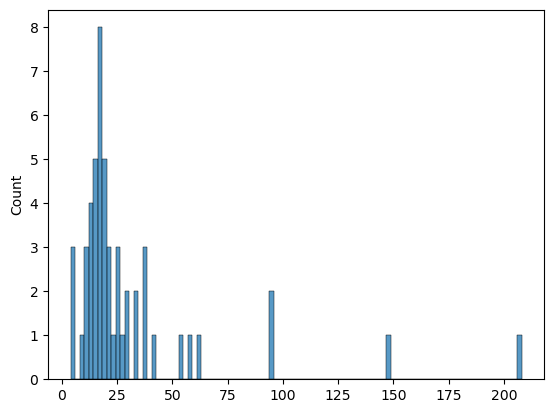

In [166]:
sns.histplot(na_count, bins=100)

Text(0.5, 0, 'NaN ratio')

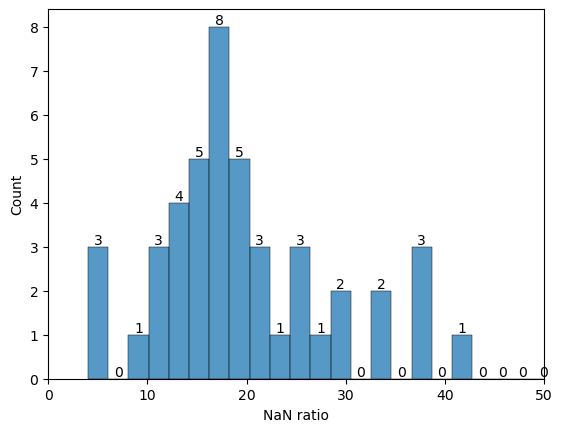

In [167]:
ax = sns.histplot(na_count, bins=100)
ax.set_xlim(0, 50)
ax.bar_label(ax.containers[1])
ax.set_xlabel('NaN ratio')

In [168]:
sr_t = df_tics.pivot_table(index='date', columns=['tic']).isna().close.sum() < 50
tic_list_ = tic_list
tic_list = list(sr_t.index[sr_t])
df_tics = df_tics[df_tics.tic.isin(tic_list)]
df_tics = df_tics.pivot_table(index='date', columns=['tic'])
df_tics.isna().close.sum()

tic
0001.HK    29
0002.HK    26
0005.HK    15
0006.HK    18
0011.HK    18
0012.HK    19
0016.HK    13
0017.HK    30
0027.HK     4
0066.HK    17
0101.HK    16
0175.HK    15
0267.HK    38
0291.HK    21
0322.HK    18
0386.HK    15
0669.HK     4
0688.HK    21
0700.HK     6
0762.HK    17
0823.HK    20
0857.HK    37
0868.HK    15
0883.HK    34
0939.HK    33
0941.HK    20
0981.HK    23
0992.HK    18
1038.HK    17
1044.HK    14
1088.HK    27
1093.HK    26
1109.HK    13
1177.HK    19
1398.HK    37
2007.HK    25
2020.HK    11
2319.HK    12
2331.HK    12
2382.HK    41
2388.HK    20
2628.HK    22
2688.HK    13
3968.HK    10
3988.HK    18
dtype: int64

In [171]:
df_tics.interpolate(method='time', axis=0, inplace=True)
df_tics.isna().close.sum().sum()

0

In [172]:
df_tics = df_tics.swaplevel(i = 0 , j = 1, axis = 1).stack()
df_tics_feat = pd.DataFrame()
for tic in df_tics.columns:
    stats = df_tics[tic].unstack().copy()
    stats = stockstats.StockDataFrame.retype(stats)

    df = pd.DataFrame(index=stats.index)
    df['tic'] = tic

    for f in FEATURES:
        df[f] = stats[f]

    # regularization
    df['close_'] = df['close']
    for col in ['open', 'high', 'low', 'close']:
        df[col] = df[col] / stats[f'{col}_250_sma'] - 1
    df['volume'] = df['volume'] / stats['volume_20_sma'] - 1

    df['cr-ma1'] -= 100
    df['cr-ma2'] -= 100
    df['cr-ma3'] -= 100
    
    # fill nan, inf
    df.replace([-np.inf, np.inf], np.nan, inplace=True)

    df.reset_index(inplace=True)

    df_tics_feat = pd.concat([df_tics_feat, df], ignore_index=True)

In [173]:
df_tics_feat.isna().sum()

date          0
tic           0
open          0
high          0
low           0
close         0
volume        0
cr-ma3        0
cci          45
cr-ma1        0
cr-ma2        0
change        0
ppoh          0
kdjj_9        0
ppo           0
ppos          0
stochrsi    103
close_        0
dtype: int64

In [174]:
df_tics_feat.date[df_tics_feat.cci.isna()].unique()

array(['2008-01-02T00:00:00.000000000'], dtype='datetime64[ns]')

In [175]:
df_tics_feat.date[df_tics_feat.stochrsi.isna()].unique()

array(['2008-01-02T00:00:00.000000000', '2008-01-03T00:00:00.000000000',
       '2008-01-04T00:00:00.000000000', '2008-01-07T00:00:00.000000000',
       '2008-01-08T00:00:00.000000000'], dtype='datetime64[ns]')

In [176]:
df_tics_feat.pivot_table(values=['stochrsi', 'close'], index='tic',columns=['date']).stochrsi.iloc[:, :10].isna().sum().sum

date
2008-01-04    8
2008-01-07    3
2008-01-08    2
2008-01-09    0
2008-01-10    0
2008-01-11    0
2008-01-14    0
2008-01-15    0
2008-01-16    0
2008-01-17    0
dtype: int64

In [177]:
df_tics_feat = df_tics_feat[df_tics_feat.date != '2008-01-02']
df_tics_feat = df_tics_feat[df_tics_feat.date != '2008-01-03']
df_tics_feat.isna().sum()

date         0
tic          0
open         0
high         0
low          0
close        0
volume       0
cr-ma3       0
cci          0
cr-ma1       0
cr-ma2       0
change       0
ppoh         0
kdjj_9       0
ppo          0
ppos         0
stochrsi    13
close_       0
dtype: int64

In [178]:
df_tics_feat.fillna(method='bfill', inplace=True)
df_tics_feat.isna().sum().sum()

0

In [179]:
# save
for tic in df_tics_feat.tic.unique():
    df = df_tics_feat[df_tics_feat['tic'] == tic].drop(columns=['close_', 'tic'])
    csv_path = os.path.join(PREPROCESSED_HSI_DIR, f'{tic}.csv')
    if not os.path.exists(csv_path):
        print(f'Saving {tic}.')
        df.to_csv(csv_path, index=False)

Saving 0001.HK.
Saving 0002.HK.
Saving 0005.HK.
Saving 0006.HK.
Saving 0011.HK.
Saving 0012.HK.
Saving 0016.HK.
Saving 0017.HK.
Saving 0027.HK.
Saving 0066.HK.
Saving 0101.HK.
Saving 0175.HK.
Saving 0267.HK.
Saving 0291.HK.
Saving 0322.HK.
Saving 0386.HK.
Saving 0669.HK.
Saving 0688.HK.
Saving 0700.HK.
Saving 0762.HK.
Saving 0823.HK.
Saving 0857.HK.
Saving 0868.HK.
Saving 0883.HK.
Saving 0939.HK.
Saving 0941.HK.
Saving 0981.HK.
Saving 0992.HK.
Saving 1038.HK.
Saving 1044.HK.
Saving 1088.HK.
Saving 1093.HK.
Saving 1109.HK.
Saving 1177.HK.
Saving 1398.HK.
Saving 2007.HK.
Saving 2020.HK.
Saving 2319.HK.
Saving 2331.HK.
Saving 2382.HK.
Saving 2388.HK.
Saving 2628.HK.
Saving 2688.HK.
Saving 3968.HK.
Saving 3988.HK.


## DJI

In [180]:
# copy from https://www.slickcharts.com/dowjones
DJI_components = '''
#	Company	Symbol	Weight	      Price	Chg	% Chg
1	UnitedHealth Group Incorporated	UNH	9.201192	   485.70	8.82	(1.85%)
2	Goldman Sachs Group Inc.	GS	7.223885	   376.46	2.06	(0.55%)
3	Home Depot Inc.	HD	6.274593	   320.79	-4.41	(-1.36%)
4	Microsoft Corporation	MSFT	5.162454	   270.42	2.86	(1.07%)
5	McDonald's Corporation	MCD	5.158209	   263.52	-3.82	(-1.43%)
6	Caterpillar Inc.	CAT	4.817081	   248.87	-0.79	(-0.32%)
7	Amgen Inc.	AMGN	4.707874	   243.00	-1.00	(-0.41%)
8	Visa Inc. Class A	V	4.463219	   231.20	-0.12	(-0.05%)
9	Boeing Company	BA	4.143701	   214.62	-0.14	(-0.07%)
10	Honeywell International Inc.	HON	3.964454	   203.17	-2.30	(-1.12%)
11	Travelers Companies Inc.	TRV	3.646865	   187.39	-1.62	(-0.86%)
12	American Express Company	AXP	3.447939	   179.22	0.52	(0.29%)
13	Chevron Corporation	CVX	3.358991	   170.21	-3.88	(-2.23%)
14	Salesforce Inc.	CRM	3.304773	   172.44	1.16	(0.68%)
15	Johnson & Johnson	JNJ	3.152732	   164.14	0.74	(0.45%)
16	Apple Inc.	AAPL	2.983904	   153.20	-1.45	(-0.94%)
17	JPMorgan Chase & Co.	JPM	2.771664	   143.03	-0.62	(-0.43%)
18	Walmart Inc.	WMT	2.720148	   139.28	-1.70	(-1.21%)
19	Procter & Gamble Company	PG	2.701625	   139.12	-0.90	(-0.64%)
20	International Business Machines Corporation	IBM	2.620974	   134.88	-0.96	(-0.71%)
21	NIKE Inc. Class B	NKE	2.418188	   123.76	-1.57	(-1.25%)
22	3M Company	MMM	2.255535	   116.00	-0.90	(-0.77%)
23	Walt Disney Company	DIS	2.153852	   118.55	6.92	(6.20%)
24	Merck & Co. Inc.	MRK	2.03905	   107.00	1.32	(1.25%)
25	Dow Inc.	DOW	1.167514	   59.81	-0.70	(-1.16%)
26	Coca-Cola Company	KO	1.159024	   59.92	-0.15	(-0.25%)
27	Cisco Systems Inc.	CSCO	0.923052	   47.25	-0.59	(-1.23%)
28	Verizon Communications Inc.	VZ	0.782395	   40.60	0.05	(0.12%)
29	Walgreens Boots Alliance Inc.	WBA	0.708882	   36.74	0.00	(0.00%)
30	Intel Corporation	INTC	0.560507	   28.47	-0.58	(-2.00%)
'''

In [181]:
df = pd.read_csv(io.StringIO(DJI_components), sep='\t')
tic_list = df.Symbol.to_list()

In [87]:
retry_list = download_ticker_with_yfince(tic_list, RAW_DATA_DIR)

Download UNH.csv
Download GS.csv
Download HD.csv
Download MSFT.csv
Download MCD.csv
Download CAT.csv
Download AMGN.csv
Download V.csv
Download BA.csv
Download HON.csv
Download TRV.csv
Download AXP.csv
Download CVX.csv
Download CRM.csv
Download JNJ.csv
Download AAPL.csv
Download JPM.csv
Download WMT.csv
Download PG.csv
Download IBM.csv
Download NKE.csv
Download MMM.csv
Download DIS.csv
Download MRK.csv
Download DOW.csv
Download KO.csv
Download CSCO.csv
Download VZ.csv
Download WBA.csv
Download INTC.csv


In [ ]:
retry_list = download_ticker_with_yfince(retry_list, RAW_DATA_DIR)

In [88]:
download_ticker_with_yfince_within_range(tic_list, TRAIN_START_DAY, TRADE_END_DAY)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
V: from 2008-03-19 to 2023-02-08 out of range.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of

In [183]:
df_tics = load_data(tic_list, RAW_DATA_WITHIN_RANGE_DIR)
na_count = df_tics.pivot_table(index='date', columns=['tic']).isna().close.sum()


Cleaning  UNH
Drop 0 duplicated rows.
Drop 0 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  GS
Drop 0 duplicated rows.
Drop 2 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  HD
Drop 0 duplicated rows.
Drop 1 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  MSFT
Drop 0 duplicated rows.
Drop 1 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  MCD
Drop 0 duplicated rows.
Drop 1 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  CAT
Drop 0 duplicated rows.
Drop 2 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  AMGN
Drop 0 duplicated rows.
Drop 0 rows with abnormal prices.
Drop 0 rows with volume 0.

File datasets\raw_2008-01-01_2022-12-31\V.csv doesn't exist. Skip

Cleaning  BA
Drop 0 duplicated rows.
Drop 1 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  HON
Drop 0 duplicated rows.
Drop 1 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  TRV
Drop 0 duplicated r

<AxesSubplot: ylabel='Count'>

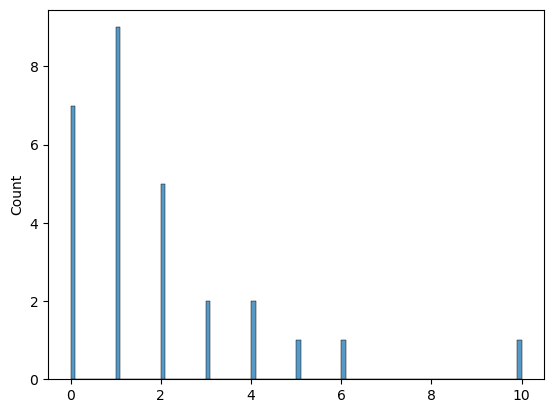

In [184]:
sns.histplot(na_count, bins=100)

In [185]:
df_tics = df_tics.pivot_table(index='date', columns=['tic'])
df_tics.isna().close.sum()

tic
AAPL     1
AMGN     0
AXP      0
BA       1
CAT      2
CRM      0
CSCO     2
CVX      0
DIS      0
GS       2
HD       1
HON      1
IBM      5
INTC     4
JNJ      1
JPM      3
KO       6
MCD      1
MMM      1
MRK      4
MSFT     1
NKE      0
PG       1
TRV      2
UNH      0
VZ      10
WBA      2
WMT      3
dtype: int64

In [186]:
df_tics.interpolate(method='time', axis=0, inplace=True)
df_tics.isna().close.sum().sum()

0

In [187]:
df_tics = df_tics.swaplevel(i = 0 , j = 1, axis = 1).stack()
df_tics_feat = pd.DataFrame()
for tic in df_tics.columns:
    stats = df_tics[tic].unstack().copy()
    stats = stockstats.StockDataFrame.retype(stats)

    df = pd.DataFrame(index=stats.index)
    df['tic'] = tic

    for f in FEATURES:
        df[f] = stats[f]

    # regularization
    df['close_'] = df['close']
    for col in ['open', 'high', 'low', 'close']:
        df[col] = df[col] / stats[f'{col}_250_sma'] - 1
    df['volume'] = df['volume'] / stats['volume_20_sma'] - 1

    df['cr-ma1'] -= 100
    df['cr-ma2'] -= 100
    df['cr-ma3'] -= 100
    
    # fill nan, inf
    df.replace([-np.inf, np.inf], np.nan, inplace=True)

    df.reset_index(inplace=True)

    df_tics_feat = pd.concat([df_tics_feat, df], ignore_index=True)
    
df_tics_feat.isna().sum()

date         0
tic          0
open         0
high         0
low          0
close        0
volume       0
cr-ma3       0
cci         28
cr-ma1       0
cr-ma2       0
change       0
ppoh         0
kdjj_9       0
ppo          0
ppos         0
stochrsi    81
close_       0
dtype: int64

In [188]:
df_tics_feat = df_tics_feat[df_tics_feat.date != '2008-01-02']
df_tics_feat = df_tics_feat[df_tics_feat.date != '2008-01-03']
df_tics_feat.isna().sum()

date         0
tic          0
open         0
high         0
low          0
close        0
volume       0
cr-ma3       0
cci          0
cr-ma1       0
cr-ma2       0
change       0
ppoh         0
kdjj_9       0
ppo          0
ppos         0
stochrsi    25
close_       0
dtype: int64

In [189]:
df_tics_feat.fillna(method='bfill', inplace=True)
df_tics_feat.isna().sum().sum()

0

In [190]:
# save
for tic in df_tics_feat.tic.unique():
    df = df_tics_feat[df_tics_feat['tic'] == tic].drop(columns=['close_', 'tic'])
    csv_path = os.path.join(PREPROCESSED_DJIA_DIR, f'{tic}.csv')
    if not os.path.exists(csv_path):
        print(f'Saving {tic}.')
        df.to_csv(csv_path, index=False)

## DAX30

In [191]:
# Copy from 
DAX30_component = '''
Symbol	Company Name	Last Price	Change	% Change	Volume
HNR1.DE	Hannover Rück SE	181.75	0.00	0.00%	21,182
1COV.DE	Covestro AG	42.57	0.05	+0.12%	160,831
AIR.DE	Airbus SE	113.60	0.30	+0.26%	68,162
BAS.DE	BASF SE	53.00	0.14	+0.26%	406,746
RWE.DE	RWE Aktiengesellschaft	40.49	-0.12	-0.30%	197,185
BAYN.DE	Bayer Aktiengesellschaft	62.27	-0.22	-0.35%	3,027,871
FME.DE	Fresenius Medical Care AG & Co. KGaA	36.68	-0.13	-0.35%	88,328
SY1.DE	Symrise AG	99.04	-0.44	-0.44%	71,780
ZAL.DE	Zalando SE	42.32	0.19	+0.45%	158,081
DTE.DE	Deutsche Telekom AG	20.26	0.11	+0.55%	1,418,280
FRE.DE	Fresenius SE & Co. KGaA	27.64	-0.18	-0.65%	252,857
LIN.DE	Linde plc	313.50	-2.10	-0.67%	124,968
BEI.DE	Beiersdorf Aktiengesellschaft	110.55	0.75	+0.68%	35,654
CON.DE	Continental Aktiengesellschaft	71.16	0.50	+0.71%	44,916
MTX.DE	MTU Aero Engines AG	227.00	1.60	+0.71%	15,685
ADS.DE	adidas AG	155.26	1.26	+0.82%	65,209
MRK.DE	MERCK Kommanditgesellschaft auf Aktien	186.55	1.55	+0.84%	96,058
SHL.DE	Siemens Healthineers AG	53.56	-0.48	-0.89%	66,525
DBK.DE	Deutsche Bank Aktiengesellschaft	11.78	0.11	+0.96%	2,280,258
VOW3.DE	Volkswagen AG	130.66	1.36	+1.05%	145,762
HEI.DE	HeidelbergCement AG	62.56	0.68	+1.10%	63,760
P911.DE	Dr. Ing. h.c. F. Porsche AG	115.10	1.30	+1.14%	80,614
BMW.DE	Bayerische Motoren Werke Aktiengesellschaft	98.70	1.13	+1.16%	159,290
ALV.DE	Allianz SE	223.35	2.60	+1.18%	474,631
DPW.DE	Deutsche Post AG	41.92	0.51	+1.24%	453,072
DTG.DE	Daimler Truck Holding AG	31.83	0.52	+1.64%	327,260
IFX.DE	Infineon Technologies AG	36.10	0.59	+1.66%	450,803
ENR.DE	Siemens Energy AG	18.92	0.46	+2.46%	452,242
DB1.DE	Deutsche Börse AG	171.50	5.20	+3.13%	127,123
SIE.DE	Siemens Aktiengesellschaft	151.40	11.34	+8.10%	1,537,042
'''

In [192]:
df = pd.read_csv(io.StringIO(DAX30_component), sep='\t')
tic_list = df.Symbol.to_list()

In [15]:
retry_list = download_ticker_with_yfince(tic_list, RAW_DATA_DIR)

File datasets\raw\HNR1.DE.csv already exist. Skip
File datasets\raw\1COV.DE.csv already exist. Skip
File datasets\raw\AIR.DE.csv already exist. Skip
File datasets\raw\BAS.DE.csv already exist. Skip
File datasets\raw\RWE.DE.csv already exist. Skip
File datasets\raw\BAYN.DE.csv already exist. Skip
File datasets\raw\FME.DE.csv already exist. Skip
File datasets\raw\SY1.DE.csv already exist. Skip
File datasets\raw\ZAL.DE.csv already exist. Skip
File datasets\raw\DTE.DE.csv already exist. Skip
File datasets\raw\FRE.DE.csv already exist. Skip
File datasets\raw\LIN.DE.csv already exist. Skip
File datasets\raw\BEI.DE.csv already exist. Skip
File datasets\raw\_CON.DE.csv already exist. Skip
File datasets\raw\MTX.DE.csv already exist. Skip
File datasets\raw\ADS.DE.csv already exist. Skip
File datasets\raw\MRK.DE.csv already exist. Skip
File datasets\raw\SHL.DE.csv already exist. Skip
File datasets\raw\DBK.DE.csv already exist. Skip
File datasets\raw\VOW3.DE.csv already exist. Skip
File datasets\r

In [ ]:
retry_list = download_ticker_with_yfince(retry_list, RAW_DATA_DIR)

In [11]:
download_ticker_with_yfince_within_range(tic_list, TRAIN_START_DAY, TRADE_END_DAY)

1COV.DE: from 2015-10-06 to 2023-02-09 out of range.
ZAL.DE: from 2014-10-01 to 2023-02-09 out of range.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
SHL.DE: from 2018-04-12 to 2023-02-09 out of range.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
P911.DE: from 2022-09-30 to 2023-02-09 out of range.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
DTG.DE: from 2021-12-10 to 2023-02-09 out of range.
[*********************100%**********************

In [194]:
df_tics = load_data(tic_list, RAW_DATA_WITHIN_RANGE_DIR)


Cleaning  HNR1.DE
Drop 5 duplicated rows.
Drop 20 rows with abnormal prices.
Drop 0 rows with volume 0.

File datasets\raw_2008-01-01_2022-12-31\1COV.DE.csv doesn't exist. Skip

Cleaning  AIR.DE
Drop 5 duplicated rows.
Drop 25 rows with abnormal prices.
Drop 1 rows with volume 0.

Cleaning  BAS.DE
Drop 1 duplicated rows.
Drop 30 rows with abnormal prices.
Drop 2 rows with volume 0.

Cleaning  RWE.DE
Drop 3 duplicated rows.
Drop 20 rows with abnormal prices.
Drop 0 rows with volume 0.

Cleaning  BAYN.DE
Drop 40 duplicated rows.
Drop 19 rows with abnormal prices.
Drop 4 rows with volume 0.

Cleaning  FME.DE
Drop 1 duplicated rows.
Drop 18 rows with abnormal prices.
Drop 1 rows with volume 0.

Cleaning  SY1.DE
Drop 3 duplicated rows.
Drop 18 rows with abnormal prices.
Drop 0 rows with volume 0.

File datasets\raw_2008-01-01_2022-12-31\ZAL.DE.csv doesn't exist. Skip

Cleaning  DTE.DE
Drop 3 duplicated rows.
Drop 26 rows with abnormal prices.
Drop 5 rows with volume 0.

Cleaning  FRE.DE
Dr

<AxesSubplot: ylabel='Count'>

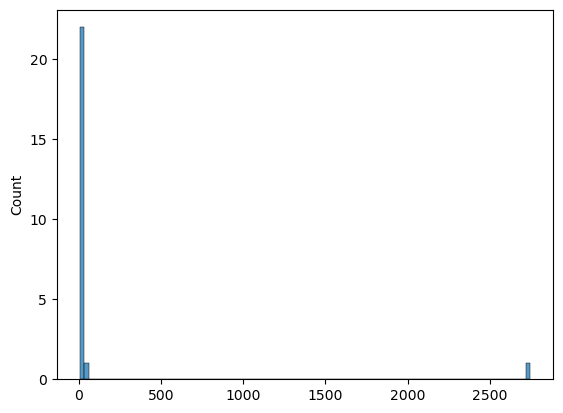

In [196]:
na_count = df_tics.pivot_table(index='date', columns=['tic']).isna().close.sum()
sns.histplot(na_count, bins=100)

Text(0.5, 0, 'NaN ratio')

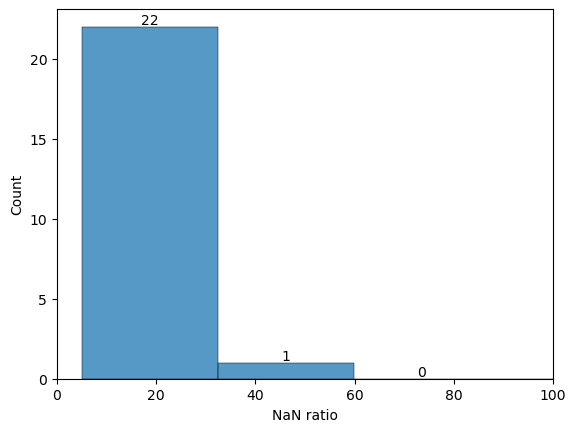

In [201]:
ax = sns.histplot(na_count, bins=100)
ax.set_xlim(0, 100)
ax.bar_label(ax.containers[1])
ax.set_xlabel('NaN ratio')

In [202]:
sr_t = df_tics.pivot_table(index='date', columns=['tic']).isna().close.sum() < 60
tic_list_ = tic_list
tic_list = list(sr_t.index[sr_t])
df_tics = df_tics[df_tics.tic.isin(tic_list)]

In [203]:
df_tics = df_tics.pivot_table(index='date', columns=['tic'])
df_tics.isna().close.sum()

tic
ADS.DE      7
AIR.DE     16
ALV.DE      9
BAS.DE     18
BAYN.DE    48
BEI.DE     11
BMW.DE     10
CON.DE     11
DB1.DE     10
DBK.DE      7
DPW.DE     24
DTE.DE     19
FME.DE      5
FRE.DE     12
HEI.DE     13
HNR1.DE    10
IFX.DE      5
MRK.DE     12
MTX.DE      8
RWE.DE      8
SIE.DE      9
SY1.DE      6
VOW3.DE    10
dtype: int64

In [204]:
df_tics.interpolate(method='time', axis=0, inplace=True)
df_tics.isna().close.sum().sum()

0

In [205]:
df_tics = df_tics.swaplevel(i = 0 , j = 1, axis = 1).stack()
df_tics_feat = pd.DataFrame()
for tic in df_tics.columns:
    stats = df_tics[tic].unstack().copy()
    stats = stockstats.StockDataFrame.retype(stats)

    df = pd.DataFrame(index=stats.index)
    df['tic'] = tic

    for f in FEATURES:
        df[f] = stats[f]

    # regularization
    df['close_'] = df['close']
    for col in ['open', 'high', 'low', 'close']:
        df[col] = df[col] / stats[f'{col}_250_sma'] - 1
    df['volume'] = df['volume'] / stats['volume_20_sma'] - 1

    df['cr-ma1'] -= 100
    df['cr-ma2'] -= 100
    df['cr-ma3'] -= 100
    
    # fill nan, inf
    df.replace([-np.inf, np.inf], np.nan, inplace=True)

    df.reset_index(inplace=True)

    df_tics_feat = pd.concat([df_tics_feat, df], ignore_index=True)
    
df_tics_feat.isna().sum()

date         0
tic          0
open         0
high         0
low          0
close        0
volume       0
cr-ma3       0
cci         23
cr-ma1       0
cr-ma2       0
change       0
ppoh         0
kdjj_9       0
ppo          0
ppos         0
stochrsi    96
close_       0
dtype: int64

In [206]:
df_tics_feat = df_tics_feat[df_tics_feat.date != '2008-01-02']
df_tics_feat = df_tics_feat[df_tics_feat.date != '2008-01-03']
df_tics_feat.isna().sum()

date         0
tic          0
open         0
high         0
low          0
close        0
volume       0
cr-ma3       0
cci          0
cr-ma1       0
cr-ma2       0
change       0
ppoh         0
kdjj_9       0
ppo          0
ppos         0
stochrsi    50
close_       0
dtype: int64

In [207]:
df_tics_feat.fillna(method='bfill', inplace=True)
df_tics_feat.isna().sum().sum()

0

In [209]:
# save
for tic in df_tics_feat.tic.unique():
    df = df_tics_feat[df_tics_feat['tic'] == tic].drop(columns=['close_', 'tic'])
    csv_path = os.path.join(PREPROCESSED_DAX30_DIR, f'{tic}.csv')
    if not os.path.exists(csv_path):
        print(f'Saving {tic}.')
        df.to_csv(csv_path, index=False)

Saving ADS.DE.
Saving AIR.DE.
Saving ALV.DE.
Saving BAS.DE.
Saving BAYN.DE.
Saving BEI.DE.
Saving BMW.DE.
Saving DB1.DE.
Saving DBK.DE.
Saving DPW.DE.
Saving DTE.DE.
Saving FME.DE.
Saving FRE.DE.
Saving HEI.DE.
Saving HNR1.DE.
Saving IFX.DE.
Saving MRK.DE.
Saving MTX.DE.
Saving RWE.DE.
Saving SIE.DE.
Saving SY1.DE.
Saving VOW3.DE.


## Download index history

### SSE50

In [19]:
# download SSE50, CSI300 from https://www.csindex.com.cn/#/indices/family/list

### HSI

In [20]:
df = yf.download('^HSI', start=TRAIN_START_DAY, end=TRADE_END_DAY)
df.to_csv(f'./datasets/HSI_{TRAIN_START_DAY}-{TRADE_END_DAY}')

[*********************100%***********************]  1 of 1 completed


### DJI

In [21]:
df = yf.download('^DJI', start=TRAIN_START_DAY, end=TRADE_END_DAY)
df.to_csv(f'./datasets/DJI_{TRAIN_START_DAY}-{TRADE_END_DAY}')

[*********************100%***********************]  1 of 1 completed


### DAX30

In [23]:
df = yf.download('^GDAXI', start=TRAIN_START_DAY, end=TRADE_END_DAY)
df.to_csv(f'./datasets/DAX30_{TRAIN_START_DAY}-{TRADE_END_DAY}')

[*********************100%***********************]  1 of 1 completed


# Setup environment

In [47]:
dataset_dir = os.path.join(PREPROCESSED_DATA_DIR, 'SSE50')
# load data

df_dict = {}
_, _, files = next(os.walk(dataset_dir))
for file in files:
    processed_file_path = os.path.join(dataset_dir, file)   
    df = pd.read_csv(processed_file_path, index_col=False)
    tic = file.replace('.csv', '')
    df_dict[tic] = df.copy()

In [48]:
df_dict_train, df_dict_test, df_dict_trade = split_data(df_dict, TEST_START_DAY, TRADE_START_DAY)

In [61]:
def get_envs(n_tickers: int = 10, seed=None) -> Tuple[MultiStockTradingEnv, MultiStockTradingEnv, MultiStockTradingEnv]:
    assert n_tickers <= len(df_dict_train)

    env_list = list()
    random.seed(seed)
    tic_list = random.sample(df_dict_train.keys(), n_tickers)
    print('Sampled tickers: ', tic_list)
    for _df_dict in [df_dict_train, df_dict_test, df_dict_trade]:
        if len(_df_dict) == 0:
            env_list.append(None)
        else:
            _dfs = list()
            for tic in tic_list:
                _df = _df_dict[tic].copy()
                _df['tic'] = tic
                _dfs.append(_df)
            _dfs = pd.concat(_dfs)
            # drop dates that missing data
            _dfs = _dfs.pivot_table(index=['date'], columns=['tic']).dropna().stack().reset_index()
            _dfs.sort_values(['date', 'tic'], inplace=True)
            _dfs.set_index(['date', 'tic'], inplace=True)
            env_list.append(Monitor(MultiStockTradingEnv(_dfs)))
    
    return tuple(env_list)

# Hyper parameter tuning

In [6]:
VERBOSE = 0

In [7]:
def objective_factory(
    model_name: str, 
    model_class: Type[BaseAlgorithm], 
    sample_param_func: Callable[[optuna.Trial], Tuple[Dict, int]],
    ) -> Callable[[optuna.Trial], float]:
    
    def objective(trial: optuna.Trial):
        model_path = os.path.join(MODEL_DIR, model_name)
        model_path = os.path.join(model_path, f'trial_{trial.number}_best_model')
        tb_log_path = os.path.join(TENSORBOARD_LOG_DIR, model_name)
        check_and_make_directories([model_path, tb_log_path])

        # Create model with sampled hyperparameters and 
        # train it with early stop callback    
        hyperparameters, total_timesteps = sample_param_func(trial)
        hyperparameters['tensorboard_log'] = '/root/tf-logs' # tb_log_path # or 

        env_train, env_test, _ =  get_envs()
        model = model_class('MlpPolicy', env_train, **hyperparameters)

        stop_train_callback = StopTrainingOnNoModelImprovement(
            max_no_improvement_evals=4, min_evals=2, verbose=VERBOSE)
        eval_callback = EvalCallback(
            env_test, 
            callback_after_eval=stop_train_callback,
            n_eval_episodes=3,
            eval_freq=10000,
            best_model_save_path=model_path, 
            verbose=VERBOSE
            )

        # deal with gradient explosion
        try:
            model.learn(total_timesteps=total_timesteps, 
                tb_log_name=f'{model_name}_{trial.number}', callback=eval_callback)
        except ValueError as e:
            # Return when gradient exploded.
            print(e)
            return -9
        except RuntimeError as e:
            # Catch CUDA OOM
            print(e)
            return -9

        # validation
        mean_reward, _ = evaluate_policy(model, env_test, n_eval_episodes=3)

        return mean_reward

    return objective

In [8]:
def tune(
    model_name: str, 
    model_class: Type[BaseAlgorithm],
    sample_param_func: Callable[[optuna.Trial], Any],
    n_trials: int = 100, 
    callbacks: List[Callable] = None
    ) -> optuna.Study:

    sampler = optuna.samplers.TPESampler(seed=None)
    objective = objective_factory(model_name, model_class, sample_param_func)

    study_name = f'{model_name}_study'
    study = optuna.create_study(
        study_name=study_name,
        storage=f'sqlite:///{study_name}',
        direction='maximize',
        sampler=sampler,
        pruner=optuna.pruners.HyperbandPruner(),
        load_if_exists=True
        )
    study.optimize(
        objective, 
        n_trials=n_trials,
        callbacks=callbacks,
        )

    return study

In [ ]:
# to alleviate CUDA OOM
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = 'max_split_size_mb:64'

In [ ]:
# study_A2C = tune('A2C', A2C, \
#     sample_param_func=sample_a2c_param)

# plot_optimization_history(study_A2C)
# plot_param_importances(study_A2C)

study_TQC = tune('TQC', TQC, \
    sample_param_func=sample_tqc_param)

plot_optimization_history(study_TQC)
plot_param_importances(study_TQC)

# Exp

In [22]:
SEED = [114, 123, 26, 103, 233] # 89, 41, 195, 202, 197
N_REPEAT = len(SEED)

In [23]:
SSE_path = './datasets/sse50.csv'
HSI_path = './datasets/hsi.csv'
DJI_path = './datasets/dji.csv'
DAX30_path = './datasets/dax30.csv'

In [32]:
SSE_path = './datasets/sse50.csv'
HSI_path = './datasets/hsi.csv'
DJI_path = './datasets/dji.csv'
DAX30_path = './datasets/dax30.csv'

if not os.path.exists(SSE_path):
    df_sse50 = pd.read_excel('./datasets/上证50_2008-2022.xlsx')

    # clean
    df_r = df_sse50[['日期Date', '开盘Open', '最高High', '最低Low', '收盘Close', '成交量（万手）Volume(M Shares)']].copy()
    df_r.set_axis(['date', 'open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)
    df_r['volume'] = df_r['volume'] * 10e4
    df_r['date'] = pd.to_datetime(df_r['date'], format='%Y%m%d')

    # split
    start = pd.to_datetime(TRADE_START_DAY, format='%Y-%m-%d')
    end = pd.to_datetime(TRADE_END_DAY, format='%Y-%m-%d')
    df_r = df_r[(df_r['date'] >= start) & (df_r['date'] <= end)]

    df_r.to_csv(SSE_path, index=False)

/root/miniconda3/envs/python3.9/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [33]:
def clean(in_dir, out_dir, start=TRADE_START_DAY, end=TRADE_END_DAY):
    if os.path.exists(out_dir):
        return
    
    df = pd.read_csv(in_dir, index_col=False)
    df.rename(columns={
        'Date': 'date',
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Adj Close' : 'adj_close',
        'Volume' : 'volume'
        }, inplace=True)

    # split
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    s = pd.to_datetime(start, format='%Y-%m-%d')
    e = pd.to_datetime(end, format='%Y-%m-%d')
    df = df[(df['date'] >= s) & (df['date'] <= e)]

    assert df['close'].isna().sum() == 0

    df.to_csv(out_dir, index=False)

In [34]:
clean('./datasets/HSI_2008-01-01-2022-12-31', HSI_path)
clean('./datasets/DJI_2008-01-01-2022-12-31', DJI_path)
clean('./datasets/DAX30_2008-01-01-2022-12-31', DAX30_path)

## SAC VS TQCR VS TQCI

### Train models

In [45]:
# setup environment
df_dict_train, df_dict_test, df_dict_trade = split_data(df_dict, TRADE_START_DAY, TRADE_START_DAY)

model_info = []

# SAC
params = {
    'learning_rate': 3 * 10 ** -5,
    'buffer_size': 10 ** 5,
    'learning_starts': 50,
    'batch_size': 2 ** 5,
    'train_freq': 2 ** 4,
    'gradient_steps': 2 ** 3,
    'target_update_interval': 10 ** 2,
    'gamma': 1,
    'policy_kwargs': {
        'net_arch': [2 ** 7] * 5
    }
}
model_info.append((SAC, params.copy()))

# TQC
params['top_quantiles_to_drop_per_net'] = 3
params['policy_kwargs'] = {
    'net_arch': [2 ** 7] * 5,
    'n_quantiles': 2 ** 8,
    'n_critics': 3
}
model_info.append((TQC, params.copy()))

# TQCI
params.pop('top_quantiles_to_drop_per_net')
params['policy_kwargs'] = {
    'net_arch': [2 ** 7] * 5,
    'n_samples_critics': 64,
    'n_samples_target_critcs': 64,
    'cos_embedding_dims': 64,
    'n_critics': 3
}

model_info.append((TQCI, params.copy()))

total_timesteps = 2000 * 200

In [62]:
for i in range(N_REPEAT):
    for model_class, params in model_info:
        model_name = model_class.__name__
        tb_log_path = os.path.join(TENSORBOARD_LOG_DIR, f'{model_name}_SSE50')
        check_and_make_directories(tb_log_path)

        params['seed'] = SEED[i]

        env_train, _, _ = get_envs(seed=SEED[i])

        model = model_class(
            'MlpPolicy',
            env_train,
            **params,
            verbose=1,
            tensorboard_log=tb_log_path,
        )
        model.learn(total_timesteps=total_timesteps, tb_log_name=f'train_{model_name}_{i}')
        
        model_path = os.path.join(MODEL_TRAINED_DIR, f'{model_name}_{i}.pth')
        model.save(model_path)

Sampled tickers:  ['600519.SS', '601857.SS', '600104.SS', '600900.SS', '603799.SS', '600031.SS', '600276.SS', '601668.SS', '603288.SS', '601688.SS']


/tmp/ipykernel_993281/3470458168.py:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  tic_list = random.sample(df_dict_train.keys(), n_tickers)


AssertionError: 

### Backtest

In [ ]:
df_dict_train, df_dict_test, df_dict_trade = split_data(df_dict, TRADE_START_DAY, TRADE_START_DAY)

In [ ]:
models = [SAC, TQC, TQCI]

result = {}
for model_class in models:
    model_name = model_class.__name__
    for i in range(N_REPEAT):
        _, _, env_trade = get_envs(seed=SEED[i])
        tics = env_trade.df.reset_index().tic.unique()
        dates = env_trade.df.reset_index().date.unique()

        model_path = os.path.join(MODEL_TRAINED_DIR, f'{model_name}_{i}.pth')
        model = model_class.load(model_path)

        list_asset, actions, rewards = simulate_trading(env_trade, model)
        result[model_name].append((tics, dates, list_asset))

with open('assets_SSE50.pkl', 'wb') as fout:
    pickle.dump(result, fout)

### Plot

In [ ]:
with open('assets_SSE50.pkl', 'rb') as fin:
    result = pickle.load(fin)

df_sse50 = pd.read_csv(SSE_path)

df_assets = pd.DataFrame()
for model_name, tuples in result.items():
    print(model_name)
   
    for tup in tuples:
        tics, dates, asset = tup
        df_t = pd.DataFrame(data={'date': dates, 'asset': asset})
        df_t['model'] = model_name
        df_t['tics'] = tics
        df_assets = pd.concat([df_assets, df_t])

    tics, dates, asset = tup
    print(tics)
    plot_asset = pd.Series(data=asset, index=dates)
    baseline_asset = df_sse50['close'][:-len(plot_asset)]
    backtest_plot(plot_asset, baseline_asset)

print('-' * 80)
sns.lineplot(df_assets, x='date', y='asset', hue='model', errorbar='sd')

## SSE50VS HSI VS DJI VS DAX30

### Train

In [ ]:
# TQCI
params = {
    'learning_rate': 3 * 10 ** -5,
    'buffer_size': 10 ** 5,
    'learning_starts': 50,
    'batch_size': 2 ** 5,
    'train_freq': 2 ** 4,
    'gradient_steps': 2 ** 3,
    'target_update_interval': 10 ** 2,
    'gamma': 1,
    'policy_kwargs': {
        'net_arch': [2 ** 7] * 5,
        'n_samples_critics': 64,
        'n_samples_target_critcs': 64,
        'cos_embedding_dims': 64,
        'n_critics': 3
    }
}

total_timesteps = 2000 * 200

for i in range(N_REPEAT):
    for index_name in ['SSE50', 'HSI', 'DJIA', 'DAX30']:

        # load data
        dataset_dir = os.path.join(PREPROCESSED_DATA_DIR, index_name)
        df_dict = {}
        _, _, files = next(os.walk(dataset_dir))
        for file in files:
            processed_file_path = os.path.join(dataset_dir, file)   
            df = pd.read_csv(processed_file_path, index_col=False)
            tic = file.replace('.csv', '')
            df_dict[tic] = df.copy()
        
        df_dict_train, df_dict_test, df_dict_trade = split_data(df_dict, TRADE_START_DAY, TRADE_START_DAY)

        env_train, _, _ = get_envs(seed=SEED[i])

        tb_log_path = os.path.join(TENSORBOARD_LOG_DIR, f'TQCI_{index_name}')
        check_and_make_directories(tb_log_path)

        model = TQCI(
            'MlpPolicy',
            env_train,
            **params,
            verbose=1,
            tensorboard_log=tb_log_path,
            seed=SEED[i]
        )
        model.learn(total_timesteps=total_timesteps, tb_log_name=f'train_tqci_on_{index_name}')
        
        model_path = os.path.join(MODEL_TRAINED_DIR, f'tqci_on_{index_name}_{i}.pth')
        model.save(model_path)

### Backtest

In [ ]:
result = {}
for i in range(N_REPEAT):
    for index_name in ['SSE50', 'HSI', 'DJIA', 'DAX30']:

        # load data
        dataset_dir = os.path.join(PREPROCESSED_DATA_DIR, index_name)
        df_dict = {}
        _, _, files = next(os.walk(dataset_dir))
        for file in files:
            processed_file_path = os.path.join(dataset_dir, file)   
            df = pd.read_csv(processed_file_path, index_col=False)
            tic = file.replace('.csv', '')
            df_dict[tic] = df.copy()
        
        df_dict_train, df_dict_test, df_dict_trade = split_data(df_dict, TRADE_START_DAY, TRADE_START_DAY)

        _, _, env_trade = get_envs(seed=SEED[i])

        tics = env_trade.df.reset_index().tic.unique()
        dates = env_trade.df.reset_index().date.unique()


        model_path = os.path.join(MODEL_TRAINED_DIR, f'tqci_on_{index_name}_{i}.pth')
        model = TQCI.load(model_path)

        list_asset, actions, rewards = simulate_trading(env_trade, model)
        result[index_name].append((tics, dates, list_asset))

with open('assets_indexes.pkl', 'wb') as fout:
    pickle.dump(result, fout)


### Plot

In [ ]:
with open('assets_indexes.pkl', 'rb') as fin:
    result = pickle.load(fin)

df_sse50 = pd.read_csv(SSE_path)
df_hsi = pd.read_csv(HSI_path)
df_dji = pd.read_csv(DJI_path)
df_dax30 = pd.read_csv(DAX30_path)
baselines = {
    'SSE50': df_sse50,
    'HSI': df_hsi,
    'DJI': df_dji,
    'DAX30': df_dax30,
}

for index_name, tuples in result.items():
    print(index_name)

    df_assets = pd.DataFrame()
    for tup in tuples:
        tics, dates, asset = tup
        df_t = pd.DataFrame(data={'date': dates, 'asset': asset})
        df_t['index_name'] = index_name
        df_t['tics'] = tics
        df_assets = pd.concat([df_assets, df_t])

    tics, dates, asset = tup
    plot_asset = pd.Series(data=asset, index=dates)

    baseline = baselines[index_name]
    baseline_asset = baseline['close'][:-len(plot_asset)]
    backtest_plot(plot_asset, baseline_asset)

    sns.lineplot(df_assets, x='day', y='asset', errorbar='sd')

## Risk distortion measure

In [ ]:
def CPW_factory(eta: float) -> Callable[[th.Tensor], th.Tensor]:
    def CPW(taus: th.Tensor) -> th.Tensor:
        taus = (taus ** eta) / ((taus ** eta + (1 - taus) ** eta) ** (1 / eta))
        return taus
    return CPW

def Wang_factory(tau: float, eta: float) -> Callable[[float], float]:
    def Wang(taus: float) -> float:
        taus = norm.cdf(norm.ppf(tau) + eta)
        return taus
    return Wang

def CVaR_factory(eta: float) -> Callable[[th.Tensor], th.Tensor]:
    def CVaR(taus: th.Tensor) -> th.Tensor:
        taus = taus * eta
        return taus
    return CVaR

def Norm_factory(eta: int) -> Callable[[th.Tensor], th.Tensor]:
    def Norm(taus: th.Tensor) -> th.Tensor:
        taus = taus.repeat([1] * len(taus.shape) + [3]).uniform_(0, 1).mean(axis=-1)
        return taus
    return Norm

def Pow_factory(eta: float) -> Callable[[th.Tensor], th.Tensor]:
    def Pow(taus: th.Tensor) -> th.Tensor:
        if eta >= 0:
            taus = taus ** (1 / (1 + eta))
        else:
            taus = 1 - (1 - taus) ** (1 / (1 - eta))
        return taus
    return Pow


In [ ]:
rdms = {}
rdms['CPW_0.71'] = CPW_factory(0.71)
rdms['Wang_-0.75'] = Wang_factory(-0.75)
rdms['CVaR_0.25'] = CVaR_factory(0.25)
rdms['CVaR_0.4'] = CVaR_factory(0.4)
rdms['Norm_3']= Norm_factory(3)
rdms['Pow_-2'] = Pow_factory(-2)

### Train

In [ ]:
# load data
dataset_dir = os.path.join(PREPROCESSED_DATA_DIR, 'SSE50')
df_dict = {}
_, _, files = next(os.walk(dataset_dir))
for file in files:
    processed_file_path = os.path.join(dataset_dir, file)   
    df = pd.read_csv(processed_file_path, index_col=False)
    tic = file.replace('.csv', '')
    df_dict[tic] = df.copy()

df_dict_train, df_dict_test, df_dict_trade = split_data(df_dict, TRADE_START_DAY, TRADE_START_DAY)

In [ ]:
# TQCI
params = {
    'learning_rate': 3 * 10 ** -5,
    'buffer_size': 10 ** 5,
    'learning_starts': 50,
    'batch_size': 2 ** 5,
    'train_freq': 2 ** 4,
    'gradient_steps': 2 ** 3,
    'target_update_interval': 10 ** 2,
    'gamma': 1,
    'policy_kwargs': {
        'net_arch': [2 ** 7] * 5,
        'n_samples_critics': 64,
        'n_samples_target_critcs': 64,
        'cos_embedding_dims': 64,
        'n_critics': 3
    }
}

total_timesteps = 2000 * 200

for i in range(N_REPEAT):
    for name, rdm in rdms.items():

        # load data
        dataset_dir = os.path.join(PREPROCESSED_DATA_DIR, 'SSE50')
        df_dict = {}
        _, _, files = next(os.walk(dataset_dir))
        for file in files:
            processed_file_path = os.path.join(dataset_dir, file)   
            df = pd.read_csv(processed_file_path, index_col=False)
            tic = file.replace('.csv', '')
            df_dict[tic] = df.copy()
        
        df_dict_train, df_dict_test, df_dict_trade = split_data(df_dict, TRADE_START_DAY, TRADE_START_DAY)

        env_train, _, _ = get_envs(seed=SEED[i])
        

        tb_log_path = os.path.join(TENSORBOARD_LOG_DIR, f'TQCI_SSE50_{name}')
        check_and_make_directories(tb_log_path)

        params['policy_kwargs']['risk_distortion_measures'] = rdm
        model = TQCI(
            'MlpPolicy',
            env_train,
            **params,
            verbose=1,
            tensorboard_log=tb_log_path,
            seed=SEED[i]
        )
        model.learn(total_timesteps=total_timesteps, tb_log_name=f'train_tqci_with_{name}')
        
        model_path = os.path.join(MODEL_TRAINED_DIR, f'tqci_with_{name}_{i}.pth')
        model.save(model_path)

### Backtest

In [ ]:
result = {}
for i in range(N_REPEAT):
    for name, rdm in rdms.items():

        _, _, env_trade = get_envs(seed=SEED[i])

        model_path = os.path.join(MODEL_TRAINED_DIR, f'tqci_with_{name}_{i}.pth')
        model = TQCI.load(model_path)

        list_asset, actions, rewards = simulate_trading(env_trade, model)
        result[name].append(list_asset)

with open('assets_risk.pkl', 'wb') as fout:
    pickle.dump(result, fout)


### Plot

In [ ]:
with open('assets_risk.pkl', 'rb') as fin:
    result = pickle.load(fin)

df_sse50 = pd.read_csv(SSE_path)

df_assets = pd.DataFrame()
for rdm_name, tuples in result.items():
    print(rdm_name)
   
    for tup in tuples:
        tics, dates, asset = tup
        df_t = pd.DataFrame(data={'date': dates, 'asset': asset})
        df_t['rdm_name'] = rdm_name
        df_t['tics'] = tics
        df_assets = pd.concat([df_assets, df_t])

    tics, dates, asset = tup
    print(tics)
    plot_asset = pd.Series(data=asset, index=dates)
    baseline_asset = df_sse50['close'][:-len(plot_asset)]
    backtest_plot(plot_asset, baseline_asset)

print('-' * 80)
sns.lineplot(df_assets, x='date', y='asset', hue='rdm_name', errorbar='sd')